# Uncovering Air Quality Patterns Through the Lens of Urban Amenities
Using Data-Driven Insights to Understand the Role of Urban Spaces in Air Quality Trends

## Machine Learning Phase

## Data Loading and Preparation

This script loads air quality datasets from **November 2023 to March 2025**. The files are stored in three folders:  
📂 **2023/** (Nov & Dec)  
📂 **2024/** (Jan - Dec)  
📂 **2025/** (Jan - Mar)  

Each dataset contains pollution data for different months. The script:  
1. Defines **file paths** for each month's dataset.  
2. Loads the data using **`pandas.read_csv()`** into separate DataFrames.  
3. Loads **`Cities.csv`**, which contains city coordinates for merging.  
   
Presented By:
**Learning Team 3**
- Francis Mark M. Cayco
- Eros Paul V. Estante
- Andgrel Heber M. Jison
- Angela Elaine F. Pelayo

In [1]:
import pandas as pd
import os
from tqdm import tqdm
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt

load_dotenv('env.env', override=True)
warnings.filterwarnings("ignore")

tqdm.pandas()

In [2]:
DATASETS_DIR = 'datasets'
OUTPUT_DIR = 'output'

In [3]:
aqi_df = []
for folder_name, folders, files in os.walk(DATASETS_DIR + '/aqi'):
    for file in files:
        aqi_df.append(pd.read_csv(folder_name + '/' + file))

aqi_df = pd.concat(aqi_df)
aqi_df.drop(['coord.lon', 'coord.lat', 'extraction_date_time'],
            axis=1, inplace=True)

print("AQI data")
display(aqi_df.head())

print("Cities data")
cities_df = pd.read_csv(DATASETS_DIR + '/cities.csv')
display(cities_df.head())

cities_df.columns

AQI data


,datetime,main.aqi,components.co,components.no,components.no2,components.o3,components.so2,components.pm2_5,components.pm10,components.nh3,city_name
0,2023-11-06 15:52:19+08:00,2.0,337.12,0.10,1.95,76.53,1.10,18.51,20.02,2.15,Alaminos
1,2023-11-06 15:52:20+08:00,2.0,343.80,0.36,5.01,60.80,3.61,8.12,9.62,3.20,Angeles City
2,2023-11-06 15:52:22+08:00,1.0,240.33,0.10,1.41,51.50,0.41,1.28,1.65,1.20,Antipolo
3,2023-11-06 15:52:23+08:00,1.0,181.91,0.05,0.41,37.55,1.33,1.12,1.28,0.36,Bacolod
4,2023-11-06 15:52:25+08:00,5.0,1001.36,0.05,5.44,254.63,28.85,102.82,131.67,9.75,Bacoor


Cities data


,city_name,coord.lon,coord.lat
0,Alaminos,119.981100,16.156100
1,Angeles City,120.583300,15.150000
2,Antipolo,121.176315,14.586435
3,Bacolod,122.963361,10.659676
4,Bacoor,120.969120,14.431760


Index(['city_name', 'coord.lon', 'coord.lat'], dtype='object')

In [4]:
aqi_df_merged = aqi_df.merge(cities_df, on='city_name', how='left')
aqi_df_merged['datetime'] = pd.to_datetime(aqi_df_merged['datetime'])
aqi_df_merged['datetime'] = aqi_df_merged['datetime'].dt.floor('H')

assert aqi_df_merged['coord.lon'].isnull().sum() == 0
assert aqi_df_merged['coord.lat'].isnull().sum() == 0

aqi_df_merged.sort_values(by=['city_name', 'datetime'], inplace=True)

In [5]:
def get_aqi(x: pd.Series):
    """
    Determines the air quality index based on pollutant concentrations.
    The index is determined by the worst category any pollutant falls into.
    """

    so2 = x['components.so2']
    no2 = x['components.no2']
    pm10 = x['components.pm10']
    pm25 = x['components.pm2_5']
    co = x['components.co']
    o3 = x['components.o3']

    categories = [
        {"name": "Good", "index": 1, "ranges": [
            (0, 20), (0, 40), (0, 20), (0, 10), (0, 60), (0, 4400)]},
        {"name": "Fair", "index": 2, "ranges": [
            (20, 80), (40, 70), (20, 50), (10, 25), (60, 100), (4400, 9400)]},
        {"name": "Moderate", "index": 3, "ranges": [
            (80, 250), (70, 150), (50, 100), (25, 50), (100, 140), (9400, 12400)]},
        {"name": "Poor", "index": 4, "ranges": [
            (250, 350), (150, 200), (100, 200), (50, 75), (140, 180), (12400, 15400)]},
        {"name": "Very Poor", "index": 5, "ranges": [(350, float('inf')), (200, float(
            'inf')), (200, float('inf')), (75, float('inf')), (180, float('inf')), (15400, float('inf'))]}
    ]

    pollutants = [so2, no2, pm10, pm25, o3, co]
    max_index = 1

    for category in categories:
        if any(lower <= pollutant < upper for pollutant, (lower, upper) in zip(pollutants, category["ranges"])):
            max_index = category["index"]

    return max_index

### Data Imputation

*Note*: We've chose to remove the imputation as it has exploded the number of rows, leading to increased memory usage and training time. 

In [6]:
dfs_imputed = []
for city_name in tqdm(aqi_df_merged['city_name'].unique()):
    api_df_filtered = aqi_df_merged[aqi_df_merged['city_name'] == city_name].copy(
    )
    api_df_filtered.set_index('datetime', inplace=True)
    # full_range = pd.date_range(start=api_df_filtered.index.min(), end=api_df_filtered.index.max(), freq="H", tz=api_df_filtered.index.tz)
    # api_df_filtered = api_df_filtered.reindex(full_range)
    # api_df_filtered.sort_index(ascending=True, inplace=True)
    # api_df_filtered[['coord.lon', 'coord.lat','city_name']] = api_df_filtered[['coord.lon', 'coord.lat','city_name']].ffill()
    # api_df_filtered.interpolate(method='time', inplace=True)

    # Recalculate AQI
    api_df_filtered['main.aqi'] = api_df_filtered.apply(get_aqi, axis=1)
    dfs_imputed.append(api_df_filtered)

aqi_df_imputed = pd.concat(dfs_imputed)
aqi_df_imputed

100%|██████████| 138/138 [00:20<00:00,  6.58it/s]


,main.aqi,components.co,components.no,components.no2,components.o3,components.so2,components.pm2_5,components.pm10,components.nh3,city_name,coord.lon,coord.lat
datetime,,,,,,,,,,,,
2023-11-06 15:00:00+08:00,2,337.12,0.10,1.95,76.53,1.10,18.51,20.02,2.15,Alaminos,119.9811,16.1561
2023-11-06 18:00:00+08:00,2,390.53,0.00,3.94,70.10,1.06,22.63,23.95,2.41,Alaminos,119.9811,16.1561
2023-11-07 00:00:00+08:00,2,514.03,0.00,8.14,43.27,2.44,21.93,23.70,10.64,Alaminos,119.9811,16.1561
2023-11-07 06:00:00+08:00,1,397.21,0.00,5.44,32.54,2.15,7.68,9.30,2.50,Alaminos,119.9811,16.1561
2023-11-07 12:00:00+08:00,3,260.35,0.45,3.17,115.87,10.85,13.75,15.41,1.41,Alaminos,119.9811,16.1561
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-15 09:00:00+08:00,1,487.33,1.98,11.48,52.21,3.87,8.40,9.62,8.99,Zamboanga City,122.0696,6.9135
2025-03-15 10:00:00+08:00,2,433.92,0.89,6.34,67.95,2.30,7.70,8.71,4.02,Zamboanga City,122.0696,6.9135
2025-03-15 11:00:00+08:00,2,360.49,0.42,2.87,67.23,1.33,5.76,6.48,2.22,Zamboanga City,122.0696,6.9135


In [ ]:
aqi_df_imputed = aqi_df_imputed[['city_name',
                                 'coord.lon', 'coord.lat', 'main.aqi']].copy()
aqi_df_imputed['Time of Day'] = aqi_df_imputed.index.hour.map(lambda x:
                                                              'Morning' if 5 <= x < 12 else
                                                              'Afternoon' if 12 <= x < 17 else
                                                              'Evening' if 17 <= x < 21 else 'Night'
                                                              )

# Removed some features as it was found to be irrelevant during the analysis
aqi_df_imputed['Day of Week'] = aqi_df_imputed.index.day_name()
# aqi_df_imputed_temp['Week Number'] = aqi_df_imputed_temp.index.isocalendar().week
# aqi_df_imputed_temp['Month Name'] = aqi_df_imputed_temp.index.month()
aqi_df_imputed['Quarter'] = aqi_df_imputed.index.quarter
# aqi_df_imputed_temp['Day of Year'] = aqi_df_imputed_temp.index.dayofyear
aqi_df_imputed['Is Weekend'] = aqi_df_imputed['Day of Week'].isin(
    ['Saturday', 'Sunday'])
aqi_df_imputed['Current Hour'] = aqi_df_imputed.index.hour

aqi_df_imputed  

,city_name,coord.lon,coord.lat,main.aqi,Time of Day,Day of Week,Quarter,Is Weekend,Current Hour
datetime,,,,,,,,,
2023-11-06 15:00:00+08:00,Alaminos,119.9811,16.1561,2,Afternoon,Monday,4,False,15
2023-11-06 18:00:00+08:00,Alaminos,119.9811,16.1561,2,Evening,Monday,4,False,18
2023-11-07 00:00:00+08:00,Alaminos,119.9811,16.1561,2,Night,Tuesday,4,False,0
2023-11-07 06:00:00+08:00,Alaminos,119.9811,16.1561,1,Morning,Tuesday,4,False,6
2023-11-07 12:00:00+08:00,Alaminos,119.9811,16.1561,3,Afternoon,Tuesday,4,False,12
...,...,...,...,...,...,...,...,...,...
2025-03-15 09:00:00+08:00,Zamboanga City,122.0696,6.9135,1,Morning,Saturday,1,True,9
2025-03-15 10:00:00+08:00,Zamboanga City,122.0696,6.9135,2,Morning,Saturday,1,True,10
2025-03-15 11:00:00+08:00,Zamboanga City,122.0696,6.9135,2,Morning,Saturday,1,True,11


## Amenity Extraction based from Coordinates

OSM and GADM datasets

In [8]:
conn = psycopg2.connect(dbname=os.getenv('DB_NAME'),
                        user=os.getenv('DB_USER'),
                        password=os.getenv('DB_PASSWORD'),
                        host=os.getenv('DB_HOST'),
                        port=os.getenv('DB_PORT'))

In [9]:
# Lets query our gadm map first and store it as our ph_shp
ph_shp = gpd.read_postgis('''
SELECT *
FROM gadm.ph
''', con=conn, geom_col='geom')
ph_shp

,gid,gid_0,name_0,gid_1,name_1,nl_name_1,gid_2,name_2,varname_2,nl_name_2,type_2,engtype_2,cc_2,hasc_2,geom
0,1,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.1_1,Bangued,None,None,Bayan|Munisipyo,Municipality,140101,PH.AB.BN,"MULTIPOLYGON (((120.6271 17.493, 120.62177 17...."
1,2,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.2_1,Boliney,None,None,Bayan|Munisipyo,Municipality,140102,PH.AB.BL,"MULTIPOLYGON (((120.99042 17.39802, 120.98631 ..."
2,3,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.3_1,Bucay,None,None,Bayan|Munisipyo,Municipality,140103,PH.AB.BU,"MULTIPOLYGON (((120.70788 17.45395, 120.70621 ..."
3,4,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.4_1,Bucloc,None,None,Bayan|Munisipyo,Municipality,140104,PH.AB.BC,"MULTIPOLYGON (((120.78956 17.41699, 120.78922 ..."
4,5,PHL,Philippines,PHL.1_1,Abra,None,PHL.1.5_1,Daguioman,None,None,Bayan|Munisipyo,Municipality,140105,PH.AB.DG,"MULTIPOLYGON (((120.92917 17.41307, 120.92464 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1642,1640,PHL,Philippines,PHL.81_1,Zamboanga Sibugay,None,PHL.81.9_1,Naga,None,None,Bayan|Munisipyo,Municipality,98309,PH.ZS.NG,"MULTIPOLYGON (((122.775 7.76833, 122.77528 7.7..."
1643,1645,PHL,Philippines,PHL.81_1,Zamboanga Sibugay,None,PHL.81.14_1,Talusan,None,None,Bayan|Munisipyo,Municipality,98314,PH.ZS.TL,"MULTIPOLYGON (((122.91917 7.34111, 122.91861 7..."
1644,1641,PHL,Philippines,PHL.81_1,Zamboanga Sibugay,None,PHL.81.10_1,Olutanga,None,None,Bayan|Munisipyo,Municipality,98310,PH.ZS.OU,"MULTIPOLYGON (((122.85805 7.27653, 122.85837 7..."
1645,1642,PHL,Philippines,PHL.81_1,Zamboanga Sibugay,None,PHL.81.11_1,Payao,None,None,Bayan|Munisipyo,Municipality,98311,PH.ZS.PY,"MULTIPOLYGON (((122.69195 7.46229, 122.69139 7..."


<Axes: >

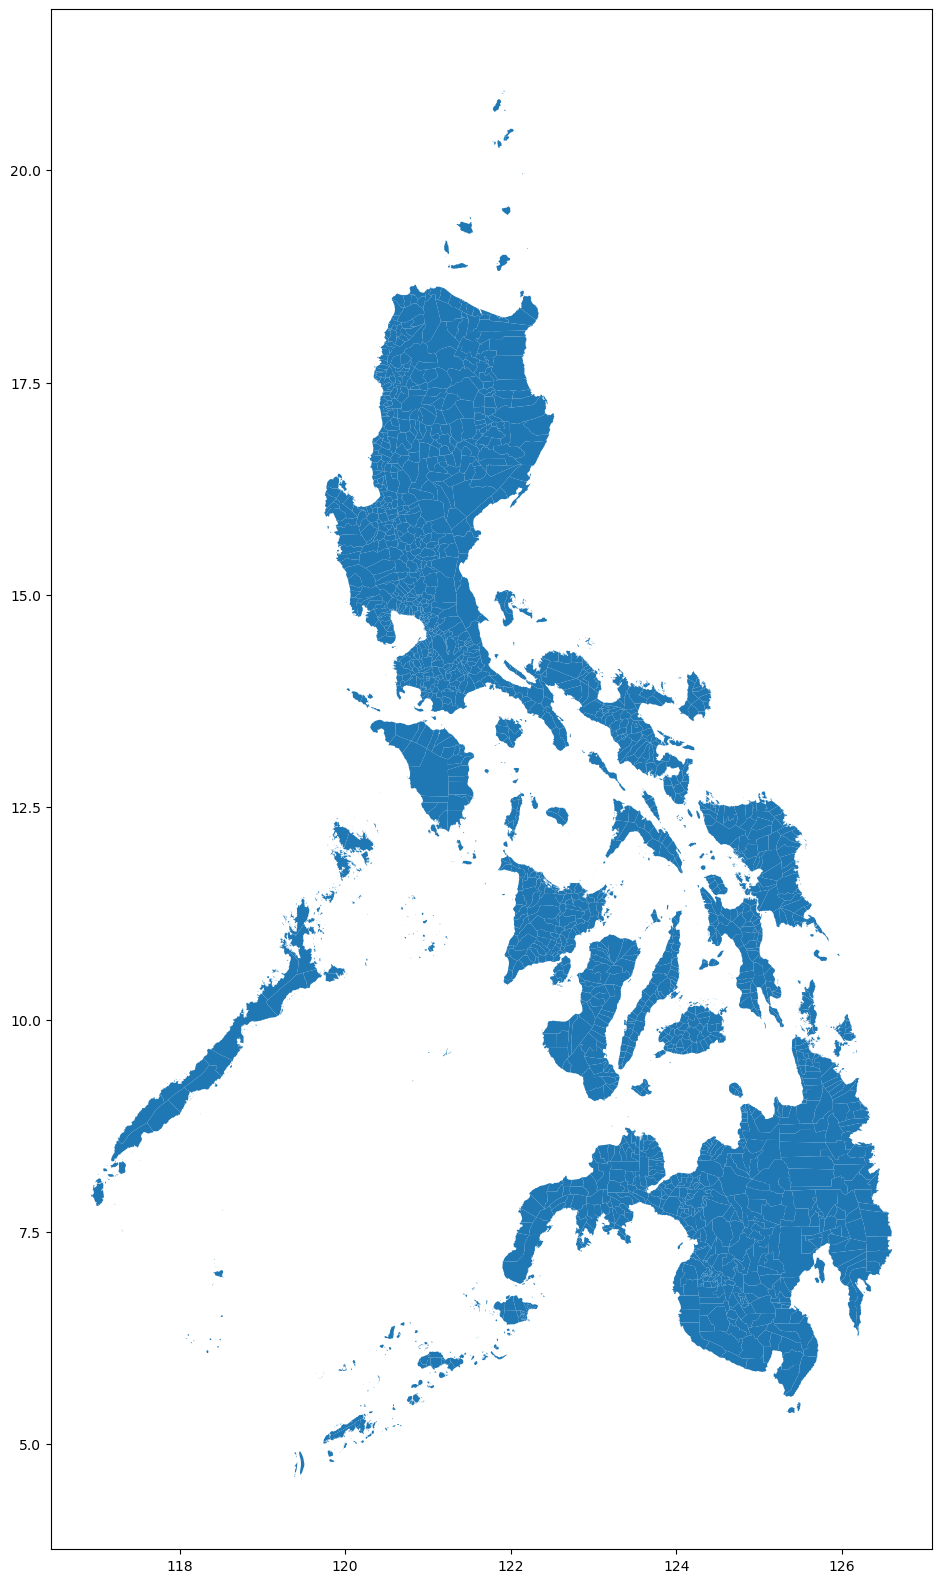

In [10]:
ph_shp.plot(figsize = (20,20))

In [11]:
ph_shp.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
# Load the Cities dataset
df_cities = pd.read_csv(DATASETS_DIR + "/cities.csv")

# Convert to GeoDataFrame with geometry column
gdf_cities = gpd.GeoDataFrame(
    df_cities, 
    geometry=gpd.points_from_xy(df_cities["coord.lon"], df_cities["coord.lat"]),
    crs="EPSG:4326"  # Assuming WGS 84 (same as most OSM/GADM datasets)
)

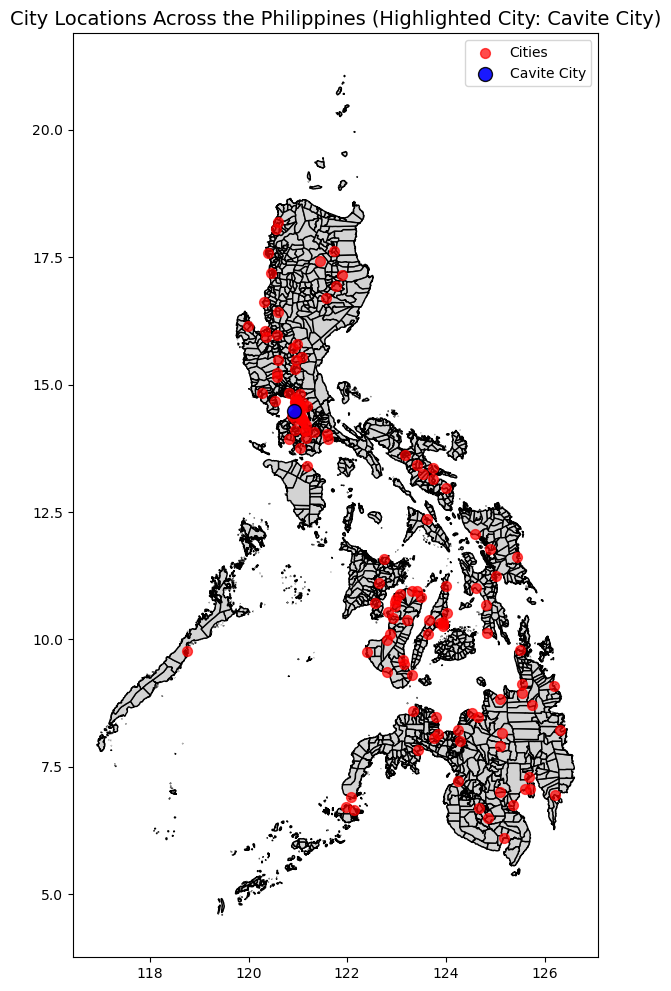

In [13]:
highlight_city = "Cavite City"

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the GADM administrative boundaries
ph_shp.plot(ax=ax, edgecolor="black", facecolor="lightgray")

# Plot all cities in red
gdf_cities[gdf_cities["city_name"] != highlight_city].plot(
    ax=ax, color="red", markersize=50, alpha=0.7, label="Cities"
)

# Plot the highlighted city in blue
gdf_cities[gdf_cities["city_name"] == highlight_city].plot(
    ax=ax, color="blue", markersize=100, alpha=0.9, label=highlight_city, edgecolor="black"
)

# Add title and legend
ax.set_title("City Locations Across the Philippines (Highlighted City: {})".format(highlight_city), fontsize=14)
ax.legend()

plt.show()


In [14]:
pip install plotly

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [15]:
query = """
        SELECT *
        FROM ph_point 
    """
# with conn.cursor() as cur:
#     cur.execute(query)  # Pass parameters safely
#     result = cur.fetchone()
# print(result)

temp = pd.read_sql(query, conn)
temp.columns
temp.dtypes

osm_id                 int64
access                object
addr:housename        object
addr:housenumber      object
addr:interpolation    object
                       ...  
wetland               object
width                 object
wood                  object
z_order               object
way                   object
Length: 69, dtype: object

In [16]:
# Function to count amenities within a 5km radius for each city
def count_amenities_5km(lon, lat, conn):
    query = """
        SELECT COUNT(*) 
        FROM ph_point 
        WHERE amenity IS NOT NULL
        AND ST_DWithin(way::geography, ST_SetSRID(ST_MakePoint(%s, %s), 4326)::geography, 5000)
    """
    with conn.cursor() as cur:
        cur.execute(query, (lon, lat))  # Pass parameters safely
        result = cur.fetchone()
    return result[0] if result else 0  # Return count or 0 if no result


# Add amenity counts for each city in gdf_cities
gdf_cities["amenity_count_5km"] = gdf_cities.apply(
    lambda row: count_amenities_5km(row["coord.lon"], row["coord.lat"], conn), axis=1
)

# Sort in ascending order of amenity count
gdf_cities = gdf_cities.sort_values(by="amenity_count_5km", ascending=True)
gdf_cities.head(10)

,city_name,coord.lon,coord.lat,geometry,amenity_count_5km
67,Lamitan,122.139674,6.659663,POINT (122.13967 6.65966),2
51,Escalante,123.499200,10.840300,POINT (123.4992 10.8403),3
56,Himamaylan,122.870600,10.098900,POINT (122.8706 10.0989),3
102,Sagay,123.424200,10.944700,POINT (123.4242 10.9447),4
24,Calaca,120.813300,13.932400,POINT (120.8133 13.9324),6
50,El Salvador,124.522500,8.563100,POINT (124.5225 8.5631),6
115,Sipalay,122.404200,9.751900,POINT (122.4042 9.7519),9
7,Bais,123.122800,9.591100,POINT (123.1228 9.5911),9
14,Bislig,126.317174,8.213526,POINT (126.31717 8.21353),11
95,Palayan City,121.085677,15.543920,POINT (121.08568 15.54392),14


In [17]:
mm_pts = gpd.read_postgis('''
SELECT p.*
FROM ph_point as p
JOIN gadm.ph as g ON st_within(p.way,g.geom)
WHERE p.amenity != 'None'
''', con=conn, geom_col="way")
mm_pts

,osm_id,access,addr:housename,addr:housenumber,addr:interpolation,admin_level,aerialway,aeroway,amenity,area,...,tourism,tower:type,tunnel,water,waterway,wetland,width,wood,z_order,way
0,4763436328,None,None,None,None,None,None,None,hospital,None,...,None,None,None,None,None,None,None,None,None,POINT (119.45895 4.84049)
1,4763438522,None,None,None,None,None,None,None,police,None,...,None,None,None,None,None,None,None,None,None,POINT (119.45865 4.84138)
2,4763436327,None,None,None,None,None,None,None,police,None,...,None,None,None,None,None,None,None,None,None,POINT (119.4607 4.84173)
3,4568341189,None,None,None,None,None,None,None,place_of_worship,None,...,None,None,None,None,None,None,None,None,None,POINT (119.84924 4.89814)
4,4887280085,None,None,None,None,None,None,None,shelter,None,...,None,None,None,None,None,None,None,None,None,POINT (119.74542 5.01282)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61618,4362363097,None,None,None,None,None,None,None,cafe,None,...,None,None,None,None,None,None,None,None,None,POINT (124.30892 13.87226)
61619,2806164238,None,None,None,None,None,None,None,fuel,None,...,None,None,None,None,None,None,None,None,None,POINT (124.13486 13.98746)
61620,4362372417,None,None,None,None,None,None,None,restaurant,None,...,None,None,None,None,None,None,None,None,None,POINT (124.28803 13.94122)
61621,4362372099,None,None,None,None,None,None,None,place_of_worship,None,...,None,None,None,None,None,None,None,None,None,POINT (124.28843 13.94082)


In [18]:
# Get unique amenity types
unique_amenities = mm_pts["amenity"].unique()
print(unique_amenities[:10])
# Count the number of unique amenity types
print("Total unique amenities:", len(unique_amenities))

['hospital' 'police' 'place_of_worship' 'shelter' 'restaurant' 'fast_food'
 'clinic' 'pharmacy' 'ferry_terminal' 'townhall']
Total unique amenities: 305


In [19]:
print("Top 10 amenities by count:") 
amenity_counts = mm_pts["amenity"].value_counts()
amenity_counts.head(10)

Top 10 amenities by count:


amenity
restaurant          8845
school              5850
bank                5366
fast_food           5247
place_of_worship    4648
fuel                3798
pharmacy            2955
cafe                2167
parking             1655
townhall            1174
Name: count, dtype: int64

## Combining the Air Quality Data Set and the Amenity type count

First, let's get the 100 most frequent amenities in mm_pts:

In [20]:
# Get the top 100 most common amenities
n_amenities = 25
top_n_amenities = mm_pts["amenity"].value_counts().head(n_amenities).index.tolist()
print(f"Top {n_amenities} amenities:")
print(top_n_amenities)

Top 25 amenities:
['restaurant', 'school', 'bank', 'fast_food', 'place_of_worship', 'fuel', 'pharmacy', 'cafe', 'parking', 'townhall', 'bar', 'police', 'atm', 'community_centre', 'bus_station', 'clinic', 'shelter', 'toilets', 'hospital', 'post_office', 'bench', 'public_building', 'college', 'marketplace', 'kindergarten']


Now, we modify gdf_cities to include 100 new columns (one per top amenity):

In [21]:
for amenity in top_n_amenities:
    gdf_cities[amenity] = 0  # Default count = 0

Now, for each city, count the occurrences of each amenity type within 5km:

In [22]:
# Function to count amenities of a specific type within a 5km radius
def count_amenities_by_type(lon, lat, amenity_type, conn):
    query = """
        SELECT COUNT(*) 
        FROM ph_point 
        WHERE amenity = %s
        AND ST_DWithin(way::geography, ST_SetSRID(ST_MakePoint(%s, %s), 4326)::geography, 5000)
    """
    with conn.cursor() as cur:
        cur.execute(query, (amenity_type, lon, lat))  # Query safely with parameters
        result = cur.fetchone()
    return result[0] if result else 0  # Return count or 0 if no result

# Iterate over each city in gdf_cities and update counts
for index, row in tqdm(gdf_cities.iterrows(), total=len(gdf_cities)):
    lon, lat = row["coord.lon"], row["coord.lat"]
    
    for amenity in top_n_amenities:
        gdf_cities.at[index, amenity] = count_amenities_by_type(lon, lat, amenity, conn)

gdf_cities.head()


100%|██████████| 138/138 [03:30<00:00,  1.52s/it]


,city_name,coord.lon,coord.lat,geometry,amenity_count_5km,restaurant,school,bank,fast_food,place_of_worship,...,clinic,shelter,toilets,hospital,post_office,bench,public_building,college,marketplace,kindergarten
67,Lamitan,122.139674,6.659663,POINT (122.13967 6.65966),2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51,Escalante,123.499200,10.840300,POINT (123.4992 10.8403),3,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56,Himamaylan,122.870600,10.098900,POINT (122.8706 10.0989),3,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
102,Sagay,123.424200,10.944700,POINT (123.4242 10.9447),4,0,3,0,0,1,...,0,0,0,0,0,0,0,0,0,0
24,Calaca,120.813300,13.932400,POINT (120.8133 13.9324),6,0,1,0,0,2,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Merge df_aggregated with gdf_cities to include amenity counts
df_aggregated_with_amenity_count= aqi_df_imputed.reset_index().merge(
    gdf_cities[["city_name"] + top_n_amenities], 
    on="city_name", 
    how="left"
)

In [24]:
df_aggregated_with_amenity_count

,datetime,city_name,coord.lon,coord.lat,main.aqi,Time of Day,Day of Week,Quarter,Is Weekend,Current Hour,...,clinic,shelter,toilets,hospital,post_office,bench,public_building,college,marketplace,kindergarten
0,2023-11-06 15:00:00+08:00,Alaminos,119.9811,16.1561,2,Afternoon,Monday,4,False,15,...,5,0,2,2,0,0,0,1,0,0
1,2023-11-06 18:00:00+08:00,Alaminos,119.9811,16.1561,2,Evening,Monday,4,False,18,...,5,0,2,2,0,0,0,1,0,0
2,2023-11-07 00:00:00+08:00,Alaminos,119.9811,16.1561,2,Night,Tuesday,4,False,0,...,5,0,2,2,0,0,0,1,0,0
3,2023-11-07 06:00:00+08:00,Alaminos,119.9811,16.1561,1,Morning,Tuesday,4,False,6,...,5,0,2,2,0,0,0,1,0,0
4,2023-11-07 12:00:00+08:00,Alaminos,119.9811,16.1561,3,Afternoon,Tuesday,4,False,12,...,5,0,2,2,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609087,2025-03-15 09:00:00+08:00,Zamboanga City,122.0696,6.9135,1,Morning,Saturday,1,True,9,...,4,0,4,2,3,0,1,1,1,0
609088,2025-03-15 10:00:00+08:00,Zamboanga City,122.0696,6.9135,2,Morning,Saturday,1,True,10,...,4,0,4,2,3,0,1,1,1,0
609089,2025-03-15 11:00:00+08:00,Zamboanga City,122.0696,6.9135,2,Morning,Saturday,1,True,11,...,4,0,4,2,3,0,1,1,1,0
609090,2025-03-15 12:00:00+08:00,Zamboanga City,122.0696,6.9135,1,Afternoon,Saturday,1,True,12,...,4,0,4,2,3,0,1,1,1,0


In [25]:
# df_aggregated_with_amenity_count.to_csv(OUTPUT_DIR + "/AirQualityAmenityCount.csv", index=False)
df_aggregated_with_amenity_count.to_parquet(OUTPUT_DIR + "/AirQualityAmenityCount.parquet", index=False)

*End*